In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer

from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN


In [351]:
j_coupling = 1 #coupling constant J
h_coupling = 3 #coupling constant h

In [514]:
num_qubits=14

In [515]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
ansatz = RealAmplitudes(num_qubits=num_qubits,reps=3)
qc.h(qr)
qc.compose(ansatz, inplace=True)  
observable_list=[]
observable1 = SparsePauliOp.from_list([("X"*num_qubits , h_coupling )])
observable_list.append(observable1)

for i in range(num_qubits-1):
    ob=SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(num_qubits-2-i) , j_coupling)])
    observable_list.append(ob)
    

In [516]:
observable_list

[SparsePauliOp(['XXXXXXXXXXXXXX'],
               coeffs=[3.+0.j]),
 SparsePauliOp(['ZZIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZZIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZZIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIZZIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIZZIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIZZIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIZZIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIZZIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIZZIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIZZIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIZZII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIZZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIZZ'],
               coeffs=[1.+0.j])]

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


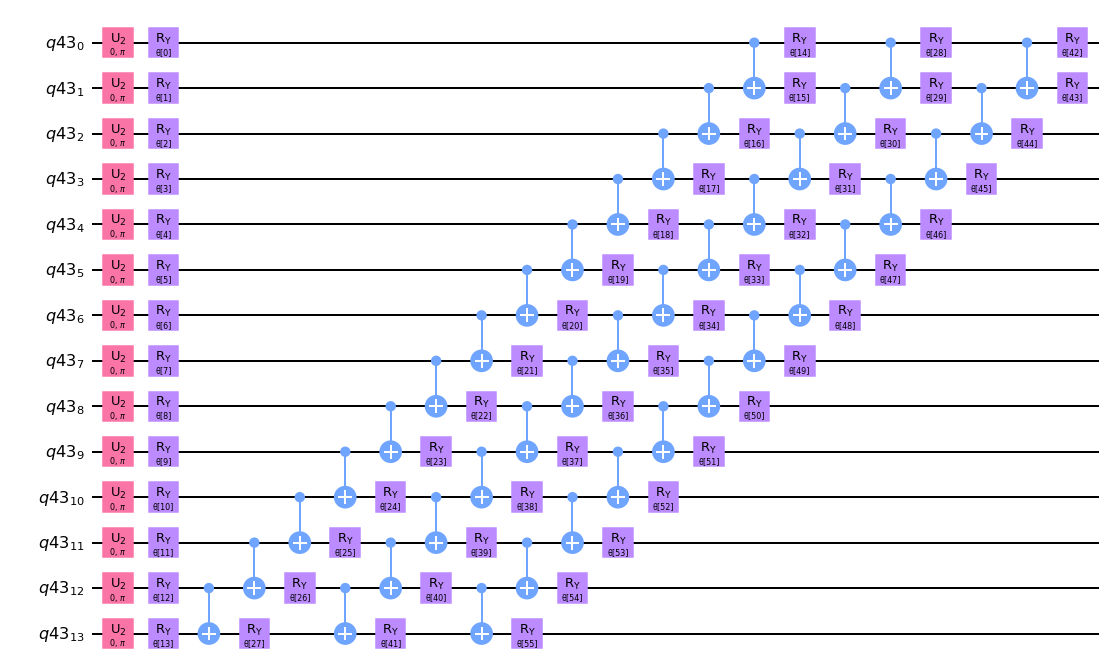

In [517]:
qc.decompose().draw('mpl')

In [518]:
qnn_list=[]
for i in range(num_qubits):
    qnn_list.append(EstimatorQNN(
    circuit=qc,
    weight_params=ansatz.parameters,
    observables=observable_list[i]
))

In [519]:
init_weights=np.random.rand(ansatz.num_parameters)*2*np.pi
#init_weights=np.zeros(ansatz.num_parameters)
weights=init_weights

In [520]:
# cost_list=[]
# gradMag_list=[]
# for i in range(100):
#     if i%10==0:
#         print(i)
#     weights=np.random.rand(ansatz.num_parameters)*2*np.pi

#     vev=0
#     grad=np.zeros(weights.shape[0])
    
#     for qnn in qnn_list:
#         vev+=qnn.forward([], weights)[0][0]
#         input_grad, weight_grad=qnn.backward([],weights)
#         grad+=weight_grad[0,0,:]
        
#     cost_list.append(vev**2)
#     gradMag_list.append(computeMag(grad)**2)
# cost_list=np.array(cost_list)
# gradMag_list=np.array(gradMag_list)

In [523]:
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()

In [524]:
def computeMag(x):
    x2=x**2
    return x2.sum()

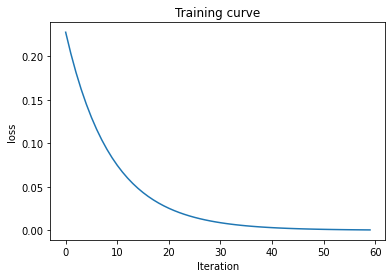

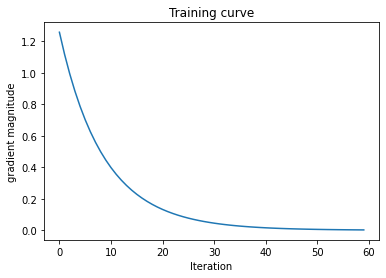

In [525]:
nSteps=60
learning_rate=1e-2
loss=[]
gradMag=[]
for i in range(nSteps):
    if i%2==0:
        print(i)
        
    #for i in range(len(qnn_list)):
    vev=0
    grad=np.zeros(weights.shape[0])
    for qnn in qnn_list:
        
        vev+=qnn.forward([], weights)[0][0]
        input_grad, weight_grad=qnn.backward([],weights)
        grad+=weight_grad[0,0,:]
        
    grad=vev*grad
    #print(grad)
    weights=weights-learning_rate*grad

    loss.append(vev**2)
    gradMag.append(computeMag(grad))
    clear_output(wait=True)
    plt.figure(1)
    callback_graph(loss)
    plt.figure(2)
    callback_graph(gradMag,"gradient magnitude")
    



In [ ]:
plt.scatter(range(nSteps),loss)

In [ ]:
plt.scatter(range(nSteps),gradMag)